<font size="12"> **Using shapefiles to calculate zonal statistics** </font>

This script allows shapefiles containing boundaries of a region of interest to be used to clip data arrays and perform calculations within a region of interest.

# Loading libraries

In [1]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
import cmocean as cm                              # Nice colormaps
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft                     # For adding features to maps
import matplotlib.gridspec as gridspec            # To create grids inside plots
import matplotlib.ticker as ticker                # To change ticks in plot axes
import os
import glob
import re
from collections import OrderedDict
from datetime import datetime
#Importing script containing functions developed to calculate timeseries
import ZonalStatsFunctions as zsf

# Set up prior to analyses

## Start client and database session
Starting a client with Dask, creating a database session through the Cosima Cookbook, and setting up variables and calculations to be performed per variable.

In [4]:
client = Client(n_workers = 8)

In [5]:
session = cc.database.create_session()

## Defining workflow per variable using dictionaries

In [6]:
varDict = OrderedDict([
    ('mld', {'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 daily',
             'start_date': [str(i)+'-01-01' for i in range(1965, 2019, 1)], #Given as a list of time steps, but can also be used with a single date
             'end_date': [str(i)+'-12-31' for i in range(1965, 2019, 1)], #As above
             'offset': np.nan, #Used to apply corrections
             'long_name': 'mixed layer depth', #Used mainly to label graphs
             'short_name': 'MLD', #Used mainly to label graphs
             'unit': 'm',
             'CICE_data': False, #If set to True, the data is treated as if it came from CICE and time corrections will be applied
             'weighted_means_season': r'/g/data/v45/la6889/Calculations/MLD/YearlySeasonal/Means',
             'weighted_means_monthly': r'/g/data/v45/la6889/Calculations/MLD/YearlyMonthly/Means',
             'decades_season': range(1964, 1975, 10),
             'weighted_means_dec_season': r'/g/data/v45/la6889/Calculations/MLD/DecadalSeasonal/Means',
             'decades_monthly': range(1965, 1976, 10),
             'weighted_means_dec_monthly': r'/g/data/v45/la6889/Calculations/MLD/DecadalMonthly/Means',
             'mean_sector_time_series': r'/g/data/v45/la6889/Figures/TimeSeries/MLD/PolarZones',
             'res': '0.1°'
               }),
    ('surface_temp',{'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 daily',
             'start_date': [str(i)+'-12-01' for i in range(1964, 2018, 1)], #Given as a list of time steps, but can also be used with a single date
             'end_date': [str(i)+'-12-31' for i in range(1965, 2019, 1)], #As above
             'offset': -273.15,
             'long_name': 'sea surface temperature', #conservative temperature
             'short_name': 'SST',
             'unit': '$^\circ$C',
             'CICE_data': False,
             'weighted_means_season': r'/g/data/v45/la6889/Calculations/SST/YearlySeasonal/Means',
             'weighted_means_monthly': r'/g/data/v45/la6889/Calculations/SST/YearlyMonthly/Means',
             'decades_season': range(1964, 2019, 10),
             'weighted_means_dec_season': r'/g/data/v45/la6889/Calculations/SST/DecadalSeasonal/Means',
             'decades_monthly': range(1965, 2019, 10),
             'weighted_means_dec_monthly': r'/g/data/v45/la6889/Calculations/SST/DecadalMonthly/Means',
             'mean_sector_time_series': r'/g/data/v45/la6889/Figures/TimeSeries/SST/PolarZones',
             'res': '0.1°'}),
    ('aice',{'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 daily',
             'start_date': [str(i)+'-12-01' for i in range(1964, 2018, 1)], #Given as a list of time steps, but can also be used with a single date
             'end_date': [str(i)+'-12-31' for i in range(1965, 2019, 1)], #As above
             'offset': np.nan,
             'long_name': 'sea ice area',
             'short_name': 'SIA',
             'unit': '$m^2$',
             'CICE_data': True,
             'weighted_means_season': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlySeasonal/Means',
             'weighted_means_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlyMonthly/Means',
             'decades_season': range(1964, 2019, 10),
             'weighted_means_dec_season': r'/g/data/v45/la6889/Calculations/SeaIceArea/DecadalSeasonal/Means',
             'decades_monthly': range(1965, 2019, 10),
             'weighted_means_dec_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/DecadalMonthly/Means',
             'mean_sector_time_series': r'/g/data/v45/la6889/Figures/TimeSeries/SeaIceArea/PolarZones',
             'res': '0.1°'}),
    ('surface_salt',{'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 daily',
             'start_date': [str(i)+'-12-01' for i in range(1964, 2018, 1)], #Given as a list of time steps, but can also be used with a single date
             'end_date': [str(i)+'-12-31' for i in range(1965, 2019, 1)], #As above
             'offset': np.nan,
             'long_name': 'sea surface salinity',
             'short_name': 'SSS',
             'unit': 'psu',
             'CICE_data': True,
             'weighted_means_season': r'/g/data/v45/la6889/Calculations/SSS/YearlySeasonal/Means',
             'weighted_means_monthly': r'/g/data/v45/la6889/Calculations/SSS/YearlyMonthly/Means',
             'decades_season': range(1964, 2019, 10),
             'weighted_means_dec_season': r'/g/data/v45/la6889/Calculations/SSS/DecadalSeasonal/Means',
             'decades_monthly': range(1965, 2019, 10),
             'weighted_means_dec_monthly': r'/g/data/v45/la6889/Calculations/SSS/DecadalMonthly/Means',
             'mean_sector_time_series': r'/g/data/v45/la6889/Figures/TimeSeries/SSS/PolarZones',
             'res': '0.1°'}),
    ('hi',{'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 daily',
             'start_date': [str(i)+'-12-01' for i in range(1964, 2018, 1)], #Given as a list of time steps, but can also be used with a single date
             'end_date': [str(i)+'-12-31' for i in range(1965, 2019, 1)], #As above
             'offset': np.nan,
             'long_name': 'sea ice thickness',
             'short_name': 'SIT',
             'unit': 'm',
             'CICE_data': True,
             'weighted_means_season': r'/g/data/v45/la6889/Calculations/SeaIceThickness/YearlySeasonal/Means',
             'weighted_means_monthly': r'/g/data/v45/la6889/Calculations/SeaIceThickness/YearlyMonthly/Means',
             'decades_season': range(1964, 2019, 10),
             'weighted_means_dec_season': r'/g/data/v45/la6889/Calculations/SeaIceThickness/DecadalSeasonal/Means',
             'decades_monthly': range(1965, 2019, 10),
             'weighted_means_dec_monthly': r'/g/data/v45/la6889/Calculations/SeaIceThickness/DecadalMonthly/Means',
             'mean_sector_time_series': r'/g/data/v45/la6889/Figures/TimeSeries/SeaIceThickness/PolarZones',
             'res': '0.1°'})
])

# for p_id, p_info in x.items():
#     print(p_id, '->', p_info)
#     for keys in p_info:
#         print(keys, '->', p_info[keys])

**The code below checks the variable name in the model for a variable of interest**

In [5]:
#Name of experiment
exp = '01deg_jra55v140_iaf_cycle2'
#Querying experiment variables
expvar = cc.querying.get_variables(session, exp)
#Extract variables with keywords included in its long_name column. Force all letters to be lowercase to get matches
expvar.dropna()[expvar['long_name'].dropna().str.lower().str.match(".*area.*")] 

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
20,aice,ice area (aggregate),1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
21,aicen,"ice area, categories",1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,357,1989-04-01 00:00:00,2019-01-01 00:00:00
29,daidtd,area tendency dynamics,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,573,1971-04-01 00:00:00,2019-01-01 00:00:00
30,daidtt,area tendency thermo,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,573,1971-04-01 00:00:00,2019-01-01 00:00:00
71,tarea,area of T grid cells,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
100,uarea,area of U grid cells,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
124,aice_m,ice area (aggregate),1 monthly,output487/ice/OUTPUT/iceh.2018-12.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
125,aicen_m,"ice area, categories",1 monthly,output487/ice/OUTPUT/iceh.2018-12.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
140,daidtd_m,area tendency dynamics,1 monthly,output487/ice/OUTPUT/iceh.2018-12.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
141,daidtt_m,area tendency thermo,1 monthly,output487/ice/OUTPUT/iceh.2018-12.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00


# Loading necessary data
Set the name of the variable being analysed in this notebook. **Note that `var_id` must have the same name as the actual variable name in ACCESS-OM2.** This means that if you are interested in *sea surface temperature*, `var_id` should be set to `surface_temp`. Once you set the var_id, all values used in the script will be taken from the contents of the dictionary above.

## Setting variable of interest

In [10]:
var_id = 'mld'

# Calculating climatologies for variable of interest across the Southern Ocean
The satellite period (1979-2008) was chosen to calculate climatologies, and three climatologies were calculated:
- Overall, which includes the mean for the entire climatological period
- Seasonal, which is the mean value per season over the climatological period
- Monthly, which is the mean monthly value over the climatological period

Calculations are done in this way to avoid issues with memory.

In [12]:
# varInt = zsf.getACCESSdata(var_id, start, end, freq = varDict[var_id]['freq'], ses = session)

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [8]:
def climCalc(clim_period, clim_type = 'overall'):
    #Define output folder, where climatologies will be stored
    out_folder = os.path.join(r'/g/data/v45/la6889/Calculations/', varDict[var_id]['short_name'], 
                              'Climatologies')
    #Ensure output folder exists
    os.makedirs(out_folder, exist_ok = True)

    #Define climatological period
    clim_start_date = [f'{str(yr)}-01-01' for yr in range(clim_period[0], clim_period[1]+1)]
    clim_end_date = [f'{str(yr)}-12-31' for yr in range(clim_period[0], clim_period[1]+1)]

    #Create a data array with ones to calculate the number of days to be included
    #in the climatological calculation
    timesteps = pd.date_range(clim_start_date[0], clim_end_date[-1])
    dates_ref = xr.DataArray(data = np.ones(len(timesteps)), coords = {'time': timesteps})

    #Create empty list to store yearly, seasonal, and monthly sums
    value_sums = []

    #Extract yearly day and add up values
    for start, end in zip(clim_start_date, clim_end_date):
        varInt = zsf.getACCESSdata(var_id, start, end, freq = varDict[var_id]['freq'], ses = session)
        varInt = varInt.sel(time = slice(start, end)).chunk({'xt_ocean': 50, 'yt_ocean': 74})
        if clim_type == 'overall':
            sums_var = varInt.sum('time').expand_dims({'year': [start.split('-')[0]]})
        elif clim_type == 'seasonal':
            sums_var = varInt.groupby('time.season').sum('time').expand_dims({'year': [start.split('-')[0]]})
        elif clim_type == 'monthly':
            sums_var = varInt.groupby('time.month').sum('time').expand_dims({'year': [start.split('-')[0]]})
        value_sums.append(sums_var)

    #Remove unused variables
    del varInt, sums_var
    
    #Define number of days and file name
    if clim_type == 'overall':
        no_days = dates_ref.sum().values
        file_name = varDict[var_id]['short_name']+'_Climatology_overall_1979-2008.nc'
    elif clim_type == 'seasonal':
        no_days = dates_ref.groupby('time.season').sum()
        file_name = varDict[var_id]['short_name']+'_Climatology_seasonal_1979-2008.nc'
    elif clim_type == 'monthly':
        no_days = dates_ref.groupby('time.month').sum()
        file_name = varDict[var_id]['short_name']+'_Climatology_monthly_1979-2008.nc'

    #Concatenate yearly sums. The result should be 30 timesteps for year, 4 timestep for seasons and
    #12 timesteps for monthly
    value_sums = xr.concat(value_sums, dim = 'year')
    
    #Calculate climatology by adding up all yearly sums and dividing by 
    #the number of days in the climatological period
    clim = value_sums.sum('year')/no_days

    #Apply any offsets to the results if specified
    if not pd.isnull(varDict[var_id]['offset']):
        clim = clim+varDict[var_id]['offset']

    #Apply longitude corrections to the resulting climatology
    clim = zsf.corrlong(clim)
    
    #Saving results to disk
    clim.to_netcdf(file_name)
    
    return clim

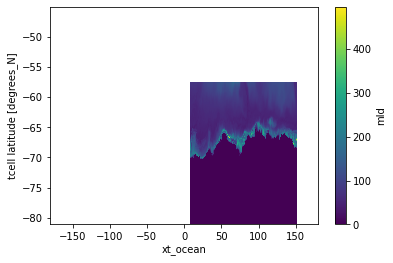

In [6]:
x = xr.open_dataarray('MLD_Climatology_overall_1979-2008.nc')
x.plot()

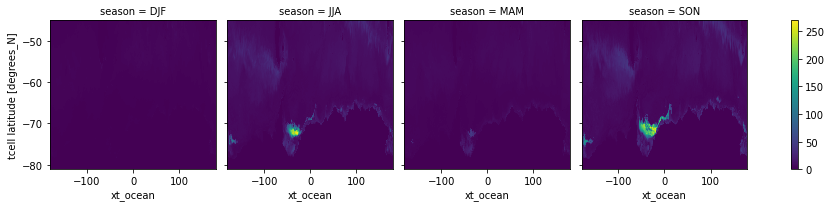

In [161]:
y = xr.open_dataarray('MLD_Climatology_seasonal_1979-2008.nc')
y.plot(col = 'season')

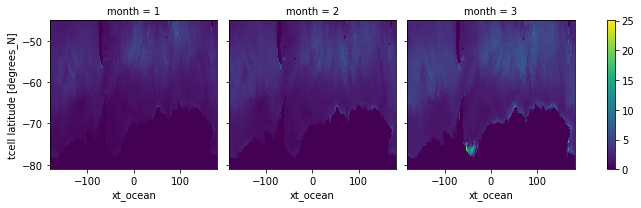

In [164]:
z = xr.open_dataarray('MLD_Climatology_monthly_1979-2008.nc')
z[0:3].plot(col = 'month')

## Loading area per pixel data

In [7]:
#Loading ocean area to create weights
area =  cc.querying.getvar(varDict[var_id]['expt'], 'area_t', session, frequency = 'static', n = -1)
area = area.sel(yt_ocean = slice(-90, -45))
area

<xarray.DataArray 'area_t' (yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(740, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-08-20
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

## Accessing variable of interest from ACCESS-OM2-01 model outputs
Remember, all this information comes from the dictionaries set in Section 1.2 and to the variable set in Section 1.3

In [8]:
SO_varInt = zsf.getACCESSdata(var_id, varDict[var_id]['start_date'][0], varDict[var_id]['end_date'][-1], 
                              freq = varDict[var_id]['freq'], ses = session)

#Applying correction (offset) if necessary
if not pd.isnull(varDict[var_id]['offset']):
    SO_varInt = SO_varInt+varDict[var_id]['offset']

#Checking data
SO_varInt

<xarray.DataArray 'mld' (time: 651, yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(651, 740, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
  * time      (time) datetime64[ns] 1964-10-16T12:00:00 ... 2018-12-16T12:00:00
Attributes: (12/14)
    long_name:      mixed layer depth determined by density criteria
    units:          m
    valid_range:    [      0. 1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ...             ...
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-08-20
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

### Correcting longitude values in ACCESS-OM2-01 model outputs
Model outputs for ACCESS-OM2-01 range from -280 to +80, which causes problems with trying to perform spatial analyses on this data. To avoid issues, longitude values need to be corrected so they range between -180 and +180. This correction require several steps as there is no way to perform a simple conversion using `xr.assign_coords` or `xr.where`.  
  
The `corrlong` function defined below will perform this corrections easily. The only input required is the dataset that needs longitude correction. It will return a the same data array with longitude values ranging from -180 to +180.

In [9]:
#Correcting data array containing variable of interest and area per pixel
SO_varIntc = zsf.corrlong(SO_varInt)
area_c = zsf.corrlong(area)

#Remove variables no longer in use
del SO_varInt, area

# Summaries at ocean basin scale

## Calculating climatologies (overall, seasonal, and monthly)
The satellite period (1979-2008) was chosen to calculate climatologies.

In [14]:
#Output folder
out_folder = os.path.join(r'/g/data/v45/la6889/Calculations/', 
                          varDict[var_id]['short_name'], 
                          'Climatologies')

#Ensure output folder exists
os.makedirs(out_folder, exist_ok = True)

#Select data to calculate climatology and chunk it into smaller sections prior to calculating the climatology
clim_data = SO_varIntc.sel(time = slice('1979', '2008')).chunk({'xt_ocean': 50, 'yt_ocean': 74})

#Calculate climatology
overall_clim = clim_data.mean('time')
#Save climatology
overall_clim.to_netcdf(os.path.join(out_folder, (varDict[var_id]['short_name']+'_Climatology_overall_1979-2008.nc')))

In [17]:
seasonal_clim = clim_data.groupby('time.season').mean('time')
seasonal_clim.to_netcdf(os.path.join(out_folder, (varDict[var_id]['short_name']+'_Climatology_seasonal_1979-2008.nc')))

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [18]:
monthly_clim = clim_data.groupby('time.month').mean('time')
monthly_clim.to_netcdf(os.path.join(out_folder, (varDict[var_id]['short_name']+'_Climatology_monthly_1979-2008.nc')))

distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

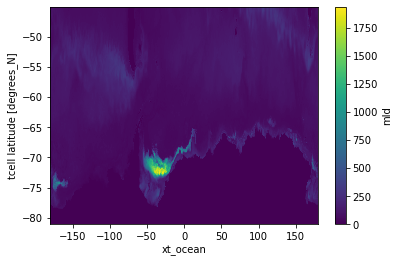

In [53]:
# yr_sums = []
# yr_sums.append(clim_data.sel(time = str(1980)).sum('time').expand_dims({'year': [1980]}))
# x = xr.concat(yr_sums, dim = 'year').sum('year')
# y = x/(366*2)
y.plot()

## Loading the shapefiles
Any shapefile can be used to create a mask and calculate zonal statistics. The boundaries used in this script were created using shapefiles from the [`measoshapes`](https://australianantarcticdivision.github.io/measoshapes/) R package. 

A detail workflow of how this mask was created can be found in the script `0_CreatingMeasoMask.ipynb`.

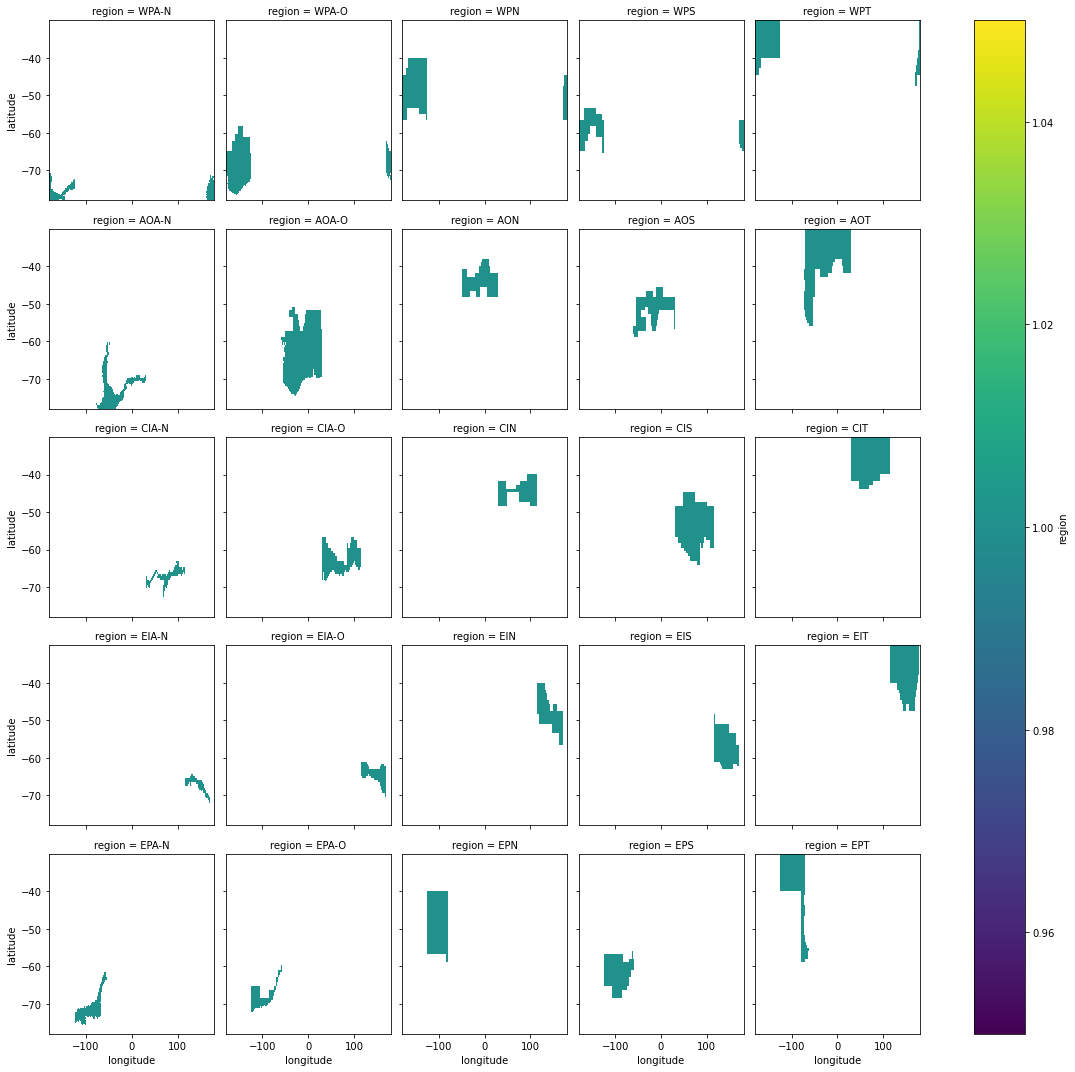

In [30]:
#Loading mask
regions = xr.load_dataarray('MEASO/MEASO_3Dmask.nc')

#Plotting mask
regions.plot(col = 'region', col_wrap = 5)

#Storing the names of each sector as a list
sectorNames = list(regions.region.values)

In [31]:

sectorNames

['WPA-N',
 'WPA-O',
 'WPN',
 'WPS',
 'WPT',
 'AOA-N',
 'AOA-O',
 'AON',
 'AOS',
 'AOT',
 'CIA-N',
 'CIA-O',
 'CIN',
 'CIS',
 'CIT',
 'EIA-N',
 'EIA-O',
 'EIN',
 'EIS',
 'EIT',
 'EPA-N',
 'EPA-O',
 'EPN',
 'EPS',
 'EPT']

In [25]:
#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for sec in sectorNames:
    MEASOregions[sec] = regions.sel(region = sec)
    
MEASOregions.keys()

dict_keys(['Atlantic', 'Central Indian', 'East Indian', 'East Pacific', 'West Pacific'])

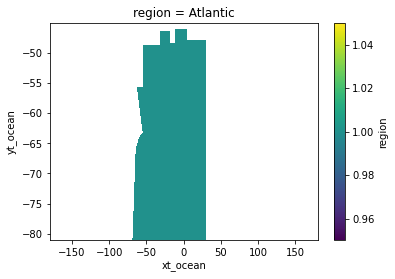

In [28]:
MEASOregions['Atlantic'].plot()

## Clipping longitude corrected data arrays

In [38]:
#Saving clipped data
out_file = r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/MEASOregions/'
#Ensuring file exists
os.makedirs(out_file, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_SIS = {}

#Saving each sector as an entry in the dictionary
for season in SI_seasons:
    for sector in sectorNames:
        clipped_SIS[f"{sector}_{season}"] = SI_data[season]*MEASOregions[sector]
        clipped_SIS[f"{sector}_{season}"] = clipped_SIS[f"{sector}_{season}"].rename(season)
        clipped_SIS[f"{sector}_{season}"].to_netcdf(os.path.join(out_file, ('SeaIce-' + sector + '_' + season + '-1965-2018.nc')))

In [9]:
clipped_SIS.keys()

dict_keys(['Atlantic_advance', 'Central Indian_advance', 'East Indian_advance', 'East Pacific_advance', 'West Pacific_advance', 'Atlantic_retreat', 'Central Indian_retreat', 'East Indian_retreat', 'East Pacific_retreat', 'West Pacific_retreat', 'Atlantic_duration', 'Central Indian_duration', 'East Indian_duration', 'East Pacific_duration', 'West Pacific_duration'])

In [8]:
#Removing variables no longer needed
del regions

In [26]:
#Accessing shapefile containing the boundaries being used to clip data. Note that the full file path is being used.
regions = geopandas.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo_wgs84.shp')
#Removing temperate regions
regions = regions.query("zone != 'Temperate'")
regions

,name,sector,zone,fill,LongName,geometry
0,WPA,West Pacific,Antarctic,#016074FF,West Pacific Antarctic,"POLYGON ((-180.00000 -64.70000, -166.00000 -64..."
1,WPA,West Pacific,Antarctic,#BCECFEFF,West Pacific Antarctic,"POLYGON ((-180.00000 -64.70000, -166.00000 -64..."
2,WPS,West Pacific,Subantarctic,#1094AFFF,West Pacific Subantarctic,"POLYGON ((-125.00000 -65.20000, -128.00000 -65..."
3,WPN,West Pacific,Northern,#054e70FF,West Pacific Northern,"POLYGON ((-125.00000 -40.00000, -125.00000 -56..."
5,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic,"POLYGON ((-125.00000 -85.00000, -125.00000 -65..."
6,EPS,East Pacific,Subantarctic,#5F9EA0FF,East Pacific Subantarctic,"POLYGON ((-125.00000 -65.20000, -125.00000 -56..."
7,EPN,East Pacific,Northern,#4B7D7EFF,East Pacific Northern,"POLYGON ((-125.00000 -56.80000, -125.00000 -40..."
9,AOA,Atlantic,Antarctic,#BCECFEFF,Atlantic Antarctic,"POLYGON ((-59.00000 -59.40791, -59.00000 -58.6..."
11,AOS,Atlantic,Subantarctic,#1094AFFF,Atlantic Subantarctic,"POLYGON ((30.00000 -56.50000, 28.00000 -56.500..."
12,AON,Atlantic,Northern,#054e70FF,Atlantic Northern,"POLYGON ((30.00000 -41.70000, 30.00000 -47.900..."


### Subsetting (breaking down) shapefiles into the smallest spatial unit of interest (optional)

In [25]:
# We are interested in polar regions only, which include continental and deep water areas
#Creating variable with sectors of interest
sectorNames = sorted(set(regions.name.values))
sectorNames

['AOA',
 'AON',
 'AOS',
 'CIA',
 'CIN',
 'CIS',
 'EIA',
 'EIN',
 'EIS',
 'EPA',
 'EPN',
 'EPS',
 'WPA',
 'WPN',
 'WPS']

In [25]:
#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
sectors = {}

#Saving each sector as an entry in the dictionary
for i in sectorNames:
    sectors[f"{i}"] = regions.query(f'name == "{i}"')

NameError: name 'sectorNames' is not defined

### Checking shapefiles and data arrays are correctly aligned (spatially)
Note that the last line can be changed to overlay any of the shapefiles used for clipping. The argument `column` is optional and it refers to the column name used to color the shapefile.

<AxesSubplot:title={'center':'time = 1964-10-01T12:00:00, spatial_ref = 0'}, xlabel='xt_ocean', ylabel='tcell latitude [degrees_N]'>

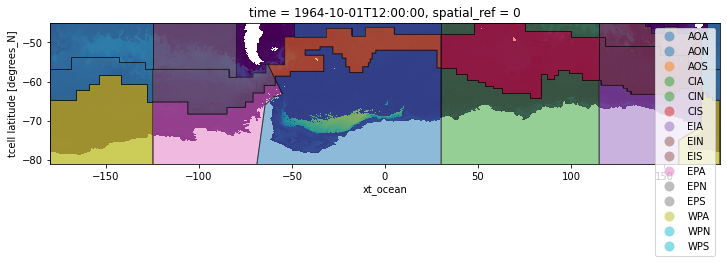

In [27]:
# Plot shapefile over the raster to ensure they both have the same CRS and cover the same area
#Initialise figure
fig, ax = plt.subplots(figsize = (12, 15))

#Plot just one timestep of the data array
SO_varIntc[0].plot(ax = ax, add_colorbar = False)

#Plot shapefile over the top and show each sector in different colour
regions.plot(ax = ax, column = 'name', legend = True, alpha = 0.5, edgecolor = 'black')

#If shapefile has been broken down into smaller boundaries, activate the line below to check boundaries correctly plotted
# sectors[sectorNames[0]].plot(ax = ax, edgecolor = 'red')

# Clipping data array using shapefiles
Note that if a shapefile includes multiple regions of interest, the resulting clipped area will cover the entire shapefile. It will not clip the data array per region in the shapefile. If the data array needs to be clipped per region, that specific region needs to be selected.

In [28]:
#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_varInt = {}
clipped_area = {}

#Saving each sector as an entry in the dictionary
for i in sectorNames:
    clipped_varInt[f"{i}"] = zsf.clipDataArray(SO_varIntc, shp = sectors[i])
    clipped_area[f"{i}"] = zsf.clipDataArray(area_c, shp = sectors[i])

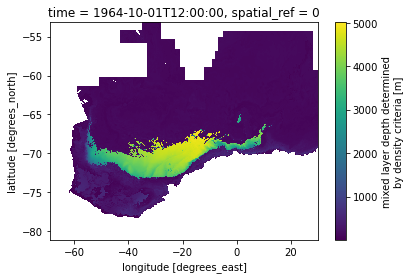

In [29]:
#Checking one of the resulting clips for the variable of interest
clipped_varInt[sectorNames[0]][0].plot()

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB


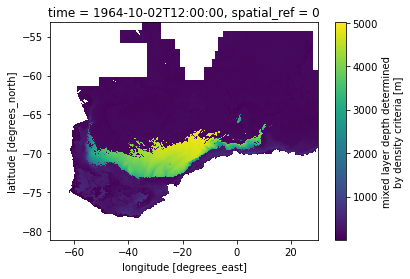

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

In [37]:
clipped_varInt[sectorNames[0]][1].plot()

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB


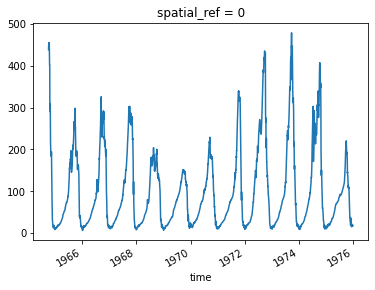

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

In [34]:
# AOA_MLD = zsf.weightedMeans(clipped_varInt[sectorNames[0]], clipped_area[sectorNames[0]])
AOA_MLD.plot()

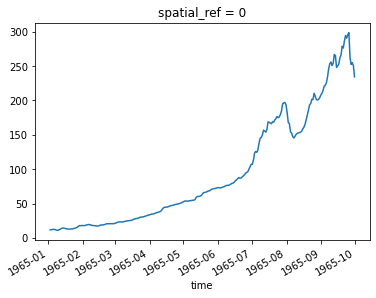

In [45]:
AOA_MLD[93:365].plot()
# 1964-10-01T12:00:00.000000000', '1964-10-02T12:00:00.000000000',
#        '1964-10-03T12:00:00.000000000', '1964-10-04T12:00:00.000000000',
#        '1964-10-05T12:00:00.000000000', '1964-10-06T12:00:00.000000000',
#        '1964-10-07T12:00:00.000000000', '1964-10-08T12:00:00.000000000',
#        '1964-10-09T12:00:00.000000000', '1964-10-10T12:00:00.000000000',
#        '1964-10-11T12:00:00.000000000', '1964-10-12T12:00:00.000000000'

# Calculating weighted means by sector
Weighted means calculated for all sectors and yearly seasonal results saved as individual netcdf files.

## Yearly seasonal

In [24]:
if not pd.isnull(varDict[var_id]['weighted_means_season']):
    os.makedirs(varDict[var_id]['weighted_means_season'], exist_ok = True)

#Loop through all sectors
for sector in sectorNames:
    #Slice data per year and calculate seasonal weighted means
    for i in np.arange(0, len(varDict[var_id]['start_date'])):
        x = zsf.weightedMeans(clipped_varInt[sector].sel(time = slice(varDict[var_id]['start_date'][i], varDict[var_id]['end_date'][i])), clipped_area[sector], meanby = 'season')
        #Add time dimension containing the year for which calculations are done
        x = zsf.addTimeYear(x, varDict[var_id]['end_date'][i].split('-')[0])
        #Save netcdf file
        x.to_netcdf(os.path.join(varDict[var_id]['weighted_means_season'], (varDict[var_id]['short_name'] + '_YearlySeasonalMeans_' + sector + '_' + 
                                                                            varDict[var_id]['start_date'][i].split('-')[0] + '-' + varDict[var_id]['end_date'][i].split('-')[0]  + '.nc')))
    #Remove unused variables
    del x

## Yearly monthly

In [31]:
if not pd.isnull(varDict[var_id]['weighted_means_monthly']):
    os.makedirs(varDict[var_id]['weighted_means_monthly'], exist_ok = True)

#Defining years within dataset
years = [i.split('-')[0] for i in varDict[var_id]['end_date']]

#Loop through all sectors
for sector in sectorNames:
    #Slice data per year and calculate seasonal weighted means
    for yr in years:
        x = zsf.weightedMeans(clipped_varInt[sector].sel(time = yr), clipped_area[sector], meanby = 'month')
        #Add time dimension containing the year for which calculations are done
        x = zsf.addTimeYear(x, yr, by = 'month')
        #Save netcdf file
        x.to_netcdf(os.path.join(varDict[var_id]['weighted_means_monthly'], (varDict[var_id]['short_name'] + '_YearlyMonthlyMeans_' + sector + '_' + yr + '.nc')))

    #Remove unused variables
    del x

#Remove unused variables
del years

## Decadal seasonal

In [ ]:
if not pd.isnull(varDict[var_id]['weighted_means_dec_season']):
    os.makedirs(varDict[var_id]['weighted_means_dec_season'], exist_ok = True)

#Loop through all sectors
for sector in sectorNames:
    #Slice data per year and calculate seasonal weighted means
    for dec in varDict[var_id]['decades_season']:
        a = clipped_varInt[sector].sel(time = slice(str(dec) + '-12-01', str(dec+10) + '-11-30'))
        maxY = a.indexes['time'].year.max()
        x = zsf.weightedMeans(a, clipped_area[sector], meanby = 'season')
        #Add time dimension containing the year for which calculations are done
        x = zsf.addTimeYear(x, f'{dec+1}-{dec+10}')
        #Save netcdf file
        x.to_netcdf(os.path.join(varDict[var_id]['weighted_means_dec_season'], (varDict[var_id]['short_name'] + '_DecadalSeasonalMeans_' + sector + '_' + str(dec+1) + '-' + str(maxY) + '.nc')))

    #Remove unused variables
    del x

## Decadal monthly

In [30]:
if not pd.isnull(varDict[var_id]['weighted_means_dec_monthly']):
    os.makedirs(varDict[var_id]['weighted_means_dec_monthly'], exist_ok = True)

#Loop through all sectors
for sector in sectorNames:
    #Slice data per year and calculate seasonal weighted means
    for dec in varDict[var_id]['decades_monthly']:
        a = clipped_varInt[sector].sel(time = slice(str(dec), str(dec+9)))
        maxY = a.indexes['time'].year.max()
        x = zsf.weightedMeans(a, clipped_area[sector], meanby = 'month')
        #Add time dimension containing the year for which calculations are done
        x = zsf.addTimeYear(x, f'{dec+1}-{dec+9}', by = 'month')
        #Save netcdf file
        x.to_netcdf(os.path.join(varDict[var_id]['weighted_means_dec_monthly'], (varDict[var_id]['short_name'] + '_DecadalMonthlyMeans_' + sector + '_' + str(dec) + '-' + str(maxY) + '.nc')))

    #Remove unused variables
    del x

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


KeyboardInterrupt: 

# Calculating maximum values per sector

## Year seasonal

In [69]:
if not pd.isnull(varDict[var_id]['weighted_max_season']):
    os.makedirs(varDict[var_id]['weighted_max_season'], exist_ok = True)

#Loop through all sectors
for sector in sectorNames:
    #Slice data per year and calculate seasonal weighted means
    for i in np.arange(0, len(varDict[var_id]['start_date'])):
        x = clipped_varInt[sector].sel(time = slice(varDict[var_id]['start_date'][i], varDict[var_id]['end_date'][i])).groupby('time').max(('xt_ocean', 'yt_ocean')).groupby('time.season').max()
        #Add time dimension containing the year for which calculations are done
        x = zsf.addTimeYear(x, varDict[var_id]['end_date'][i].split('-')[0])
        #Save netcdf file
        x.to_netcdf(os.path.join(varDict[var_id]['weighted_max_season'], (varDict[var_id]['short_name'] + '_YearlySeasonalMax_' + sector + '_' + 
                                                                            varDict[var_id]['start_date'][i].split('-')[0] + '-' + varDict[var_id]['end_date'][i].split('-')[0]  + '.nc')))
    #Remove unused variables
    del x

# Stacking data
If data array has been previously processed and outputs saved to disk, files can be accessed and stacked together using the `stackData` function from the accompanying `ZonalStatsFunctions` library.  
First the file path to the folder containing the data to be stacked must be provided.

In [7]:
in_folder = varDict[var_id]['weighted_means_season']

#Options below:
# 'weighted_means_season'
# 'weighted_means_monthly'
# 'weighted_means_dec_season'
# 'weighted_means_dec_monthly'

In [8]:
#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
stacked_data = {}

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    stacked_data[f"{sector}"] = zsf.stackData(in_folder, sector)

# Plotting results

Several ways of plotting data are included in the section below. Colourblind palettes were chosen from: [https://personal.sron.nl/~pault/#sec:qualitative].

In [9]:
#Create a dictionary to set colors that will be used to represent each sector in all figures
col = ["#4477aa", "#66ccee", "#228833", "#ccbb44", "#ee6677"]
colors = dict(zip(sectorNames, col))
colors

{'Atlantic': '#4477aa',
 'EastPacific': '#66ccee',
 'Indian': '#228833',
 'WestPacific': '#ccbb44'}

In [27]:
# maxV = []
# minV = []

# for sec in sectorNames:
#     maxV.append(stacked_data[sec].values.max())
#     minV.append(stacked_data[sec].values.max())
    
# maxV = max(maxV)
# minV = min(minV)

np.ceil(maxV*1.1)

268.0

## Seasons four panels and all areas

Text(0.5, 0.99, 'Mean seasonal mixed layer depth (MLD) across 4 sectors of the Southern Ocean')

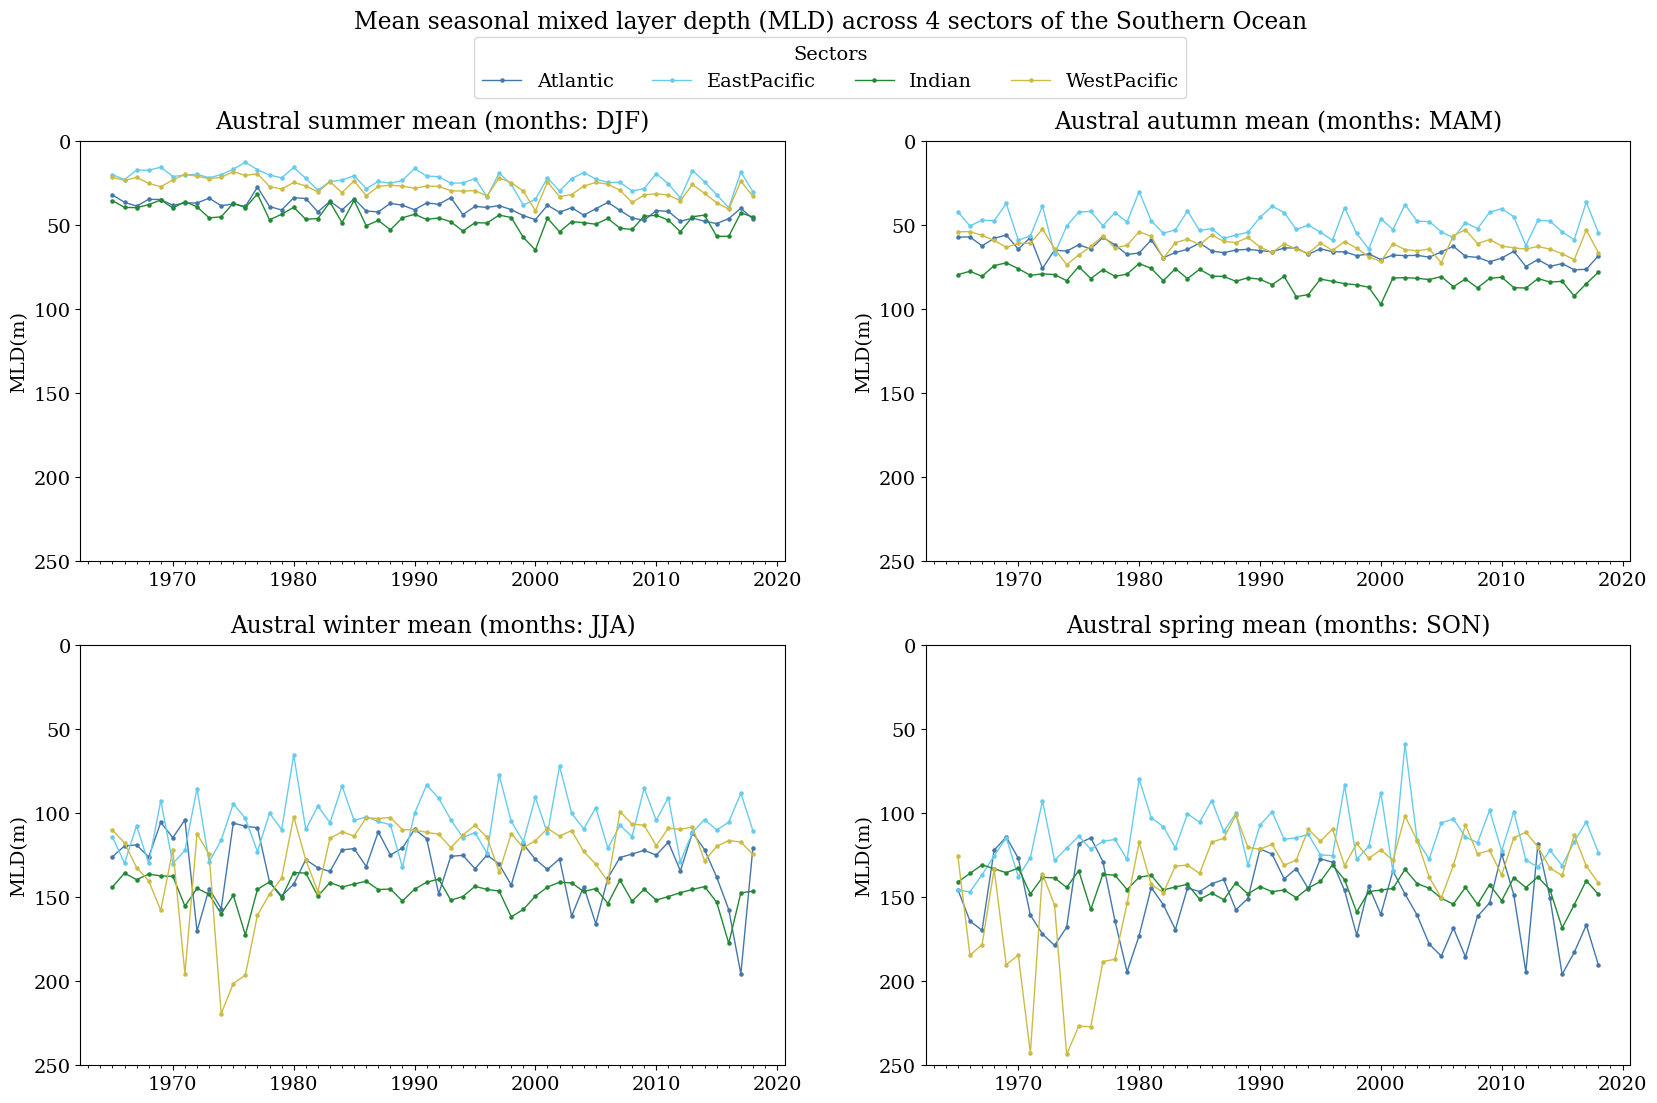

In [44]:
#Extract years included in the data arrays
years = range(int(min(stacked_data['Atlantic'].time.values)), int(max(stacked_data['Atlantic'].time.values))+1)

#Defining season names
seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 'JJA': 'Austral winter', 'SON': 'Austral spring'}

#Create composite figures
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12), constrained_layout = False)

#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
    for sec in sectorNames:
        axes[i, j].plot(years, stacked_data[sec].sel(season = season), color = colors[sec], label = sec)
    #Set title for each subplot using season dictionaries. Move the title along the y axis so it is not too far from the plot
    axes[i,j].set_title(seasonName[season] + ' mean (months: ' + season + ')', y = 1.01)
    #Change axes labels
    axes[i,j].set_ylabel(varDict[var_id]['short_name'] + '(' + varDict[var_id]['unit'] + ')')
    axes[i,j].set_xlabel('')
    axes[i,j].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    #Change y axis limits
    plt.setp(axes[i, j].set_ylim([250, 0])) #MLD
#     plt.setp(axes[i, j].set_ylim([5200, 0])) #MLD max
#     plt.setp(axes[i, j].set_ylim([-2, 5])) #SST
    #Change line width and marker type for all axes
    plt.setp(axes[i, j].lines, linewidth = 1, marker = 'o', markersize = 2.25)

#####
#Shared legend
#Extract legend labels and handles for one axes (as they are all the same)
handles, labels = axes[0,0].get_legend_handles_labels()
#Plot shared legend, add title, make it horizontal and change its location to the top of the figure 
fig.legend(handles, labels, title = 'Sectors', ncol = 4, loc = 'upper center', bbox_to_anchor = (0.5, 0.975))

#####
#Add title
fig.suptitle('Mean seasonal ' + varDict[var_id]['long_name'] + ' (' + varDict[var_id]['short_name'] + ') across ' + str(len(sectorNames)) + ' sectors of the Southern Ocean', 
             y = 0.99)
    
#####
#Save figure
plt.savefig(os.path.join(varDict[var_id]['mean_sector_time_series'], ('MeanSeasonSectors' + varDict[var_id]['short_name'] + '_FourPanels_daily.png')), dpi = 300)

### Plotting seasonal time series for each sector in a different panel

ValueError: operands could not be broadcast together with shapes (54,) (12,) 

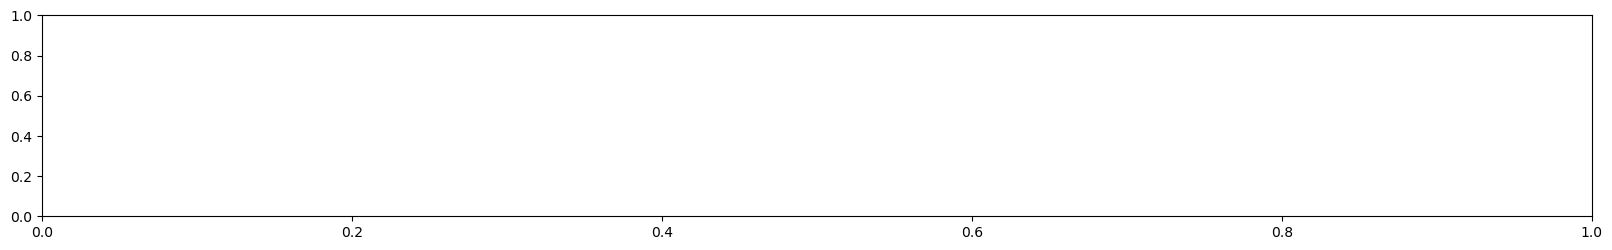

In [19]:
#Create a plot that is subdivided in four rows
fig = plt.figure(figsize = (20, 12), constrained_layout = False)
gs = gridspec.GridSpec(nrows = 4, ncols = 1)

#Create labels for x axis
x_labels = [''] 
#MLD season
# [x_labels.append(i) for i in comb_Atl.time.values]

for i in comb_Atl.season.values:
    x_labels.append(i)

#####Colors used for plotting are colourblind safe#####
#Plotting Atlantic sector
Atl = fig.add_subplot(gs[3, 0])
# Atl.plot((comb_Atl.time.values + '_' + comb_Atl.season.values), comb_Atl.values, linewidth=0.5, marker='o',markersize=1.5, color = "#000000")#MLD season
Atl.plot((comb_Atl.season.values + '_' + comb_Atl.month.values), comb_Atl.values, linewidth=0.5, marker='o',markersize=1.5, color = "#000000")
# comb_Atl.plot(linewidth=0.5, marker='o',markersize=1.5, ax = Atl, color = "#000000")
Atl.tick_params(axis = 'x', which = "major", length = 4)
[l.set_visible(False) for (i,l) in enumerate(Atl.xaxis.get_ticklabels()) if (i == 0 or i % 4 != 0)]
plt.xticks(rotation = 90)
Atl.tick_params(labelsize=12)

#Plotting Indian sector - sharing x axis with Atl
Ind = fig.add_subplot(gs[0, 0], sharex = Atl)
Ind.plot((comb_Ind.time.values + '_' + comb_Ind.season.values), comb_Ind.values, linewidth=0.5, marker='o', markersize=1.5, color = "#DDAA33")
# comb_Ind.plot(linewidth=0.5, marker='o', markersize=1.5, ax = Ind, color = "#DDAA33")
Ind.set_title("Indian Sector")

#Plotting West Pacific sector - sharing x axis with Atl
WP = fig.add_subplot(gs[1, 0], sharex = Atl)
WP.plot((comb_WP.time.values + '_' + comb_WP.season.values), comb_WP.values, linewidth=0.5, marker='o',markersize=1.5, color = "#BB5566")
WP.set_title("West Pacific Sector")

#Plotting East Pacific sector - sharing x axis with Atl
EP = fig.add_subplot(gs[2, 0], sharex = Atl)
EP.plot((comb_EP.time.values + '_' + comb_EP.season.values), comb_EP.values, linewidth=0.5, marker='o',markersize=1.5, color = "#004488")
EP.set_title("East Pacific Sector")

#Remove x tick labels so the plot does not look too crowded
plt.setp([a.set_xlabel("") for a in [Ind, WP, EP, Atl]])
# plt.setp([a.set_ylabel('MLD (m)') for a in [Ind, WP, EP, Atl]]) #MLD
plt.setp([a.set_ylabel('SST ($^\circ$C)') for a in [Ind, WP, EP, Atl]]) #SST
plt.setp([a.get_xticklabels() for a in [Ind, WP, EP]], visible = False)
plt.setp([a.xaxis.set_ticklabels(x_labels) for a in [Ind, WP, EP, Atl]])

#Set y limits to be the same for all plots - So they can be more easily compared
# plt.setp([a.set_ylim([-2.5, 5]) for a in [Ind, WP, EP, Atl]]) #SST
plt.setp([a.set_ylim([250, 0]) for a in [Ind, WP, EP, Atl]]) #MLD


#Add a main title to the plot
# plt.suptitle('Mean Seasonal Mixed Layer Depth (MLD) in the Southern Ocean between 1965 and 2018', size = 16, y = 0.93)
plt.suptitle('Mean Monthly Sea Surface Temperature (SST) in the Southern Ocean between 1965 and 2018', size = 16, y = 0.93)

#Saving the plot
# plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/MLD/PolarZones/MeanSeasonalMLD_SectorsFourPanels.png', dpi = 300)
plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/PolarZones/MeanSeasonalSST_SectorsFourPanels.png', dpi = 300)

### Plotting monthly time series for each sector in a different panel

In [45]:
Atl_s = comb_Atl.to_series()
CInd_s = comb_CInd.to_series()
EInd_s = comb_EInd.to_series()
WP_s = comb_WP.to_series()
EP_s = comb_EP.to_series()

In [46]:
Atl_s.to_csv('Atl_MLD.csv')
EInd_s.to_csv('EastInd_MLD.csv')
CInd_s.to_csv('CentralInd_MLD.csv')
WP_s.to_csv('WP_MLD.csv')
EP_s.to_csv('EP_MLD.csv')

In [23]:
#Correcting season to years and months from digits to abbreviations
zsf.corrYears(comb_Atl)
zsf.corrYears(comb_EP)
zsf.corrYears(comb_Ind)
zsf.corrYears(comb_WP)

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  font

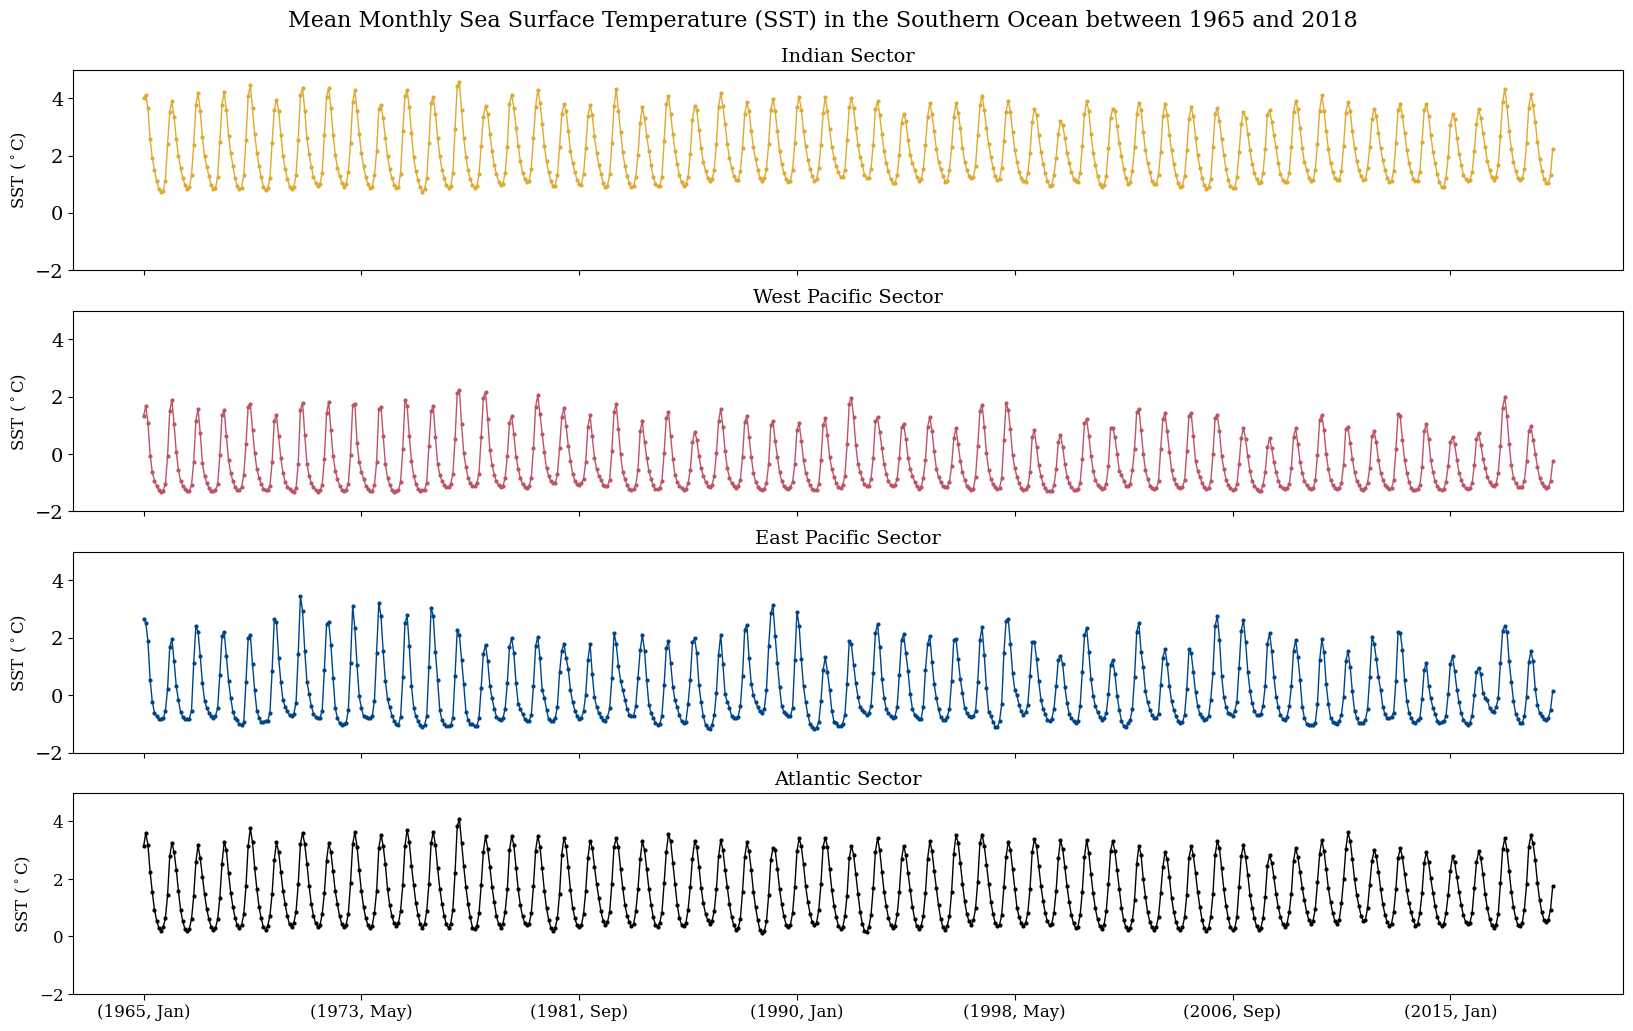

In [27]:
#Changing xarrays to series before plotting
Atl_s = comb_Atl.to_series()
Ind_s = comb_Ind.to_series()
WP_s = comb_WP.to_series()
EP_s = comb_EP.to_series()

#Create a plot that is subdivided in four rows
fig = plt.figure(figsize = (20, 12), constrained_layout = False)
gs = gridspec.GridSpec(nrows = 4, ncols = 1)

#####Colors used for plotting are colourblind safe#####
#Plotting Atlantic sector
Atl = fig.add_subplot(gs[3, 0])
Atl_s.plot(linewidth = 1, marker = 'o', markersize = 2, color = "#000000", ax = Atl)
Atl.tick_params(axis = 'x', which = "major", length = 4)
Atl.set_title("Atlantic Sector", fontsize = 14)
Atl.tick_params(labelsize = 12)

#Plotting Indian sector - sharing x axis with Atl
Ind = fig.add_subplot(gs[0, 0], sharex = Atl)
Ind_s.plot(linewidth = 1, marker='o', markersize = 2, color = "#DDAA33")
Ind.set_title("Indian Sector", fontsize = 14)

#Plotting West Pacific sector - sharing x axis with Atl
WP = fig.add_subplot(gs[1, 0], sharex = Atl)
WP_s.plot(linewidth = 1, marker = 'o', markersize = 2, color = "#BB5566")
WP.set_title("West Pacific Sector", fontsize = 14)

#Plotting East Pacific sector - sharing x axis with Atl
EP = fig.add_subplot(gs[2, 0], sharex = Atl)
EP_s.plot(linewidth = 1, marker='o', markersize = 2, color = "#004488")
EP.set_title("East Pacific Sector", fontsize = 14)

#Remove x tick labels so the plot does not look too crowded
plt.setp([a.set_xlabel("") for a in [Ind, WP, EP, Atl]])
# plt.setp([a.set_ylabel('MLD (m)') for a in [Ind, WP, EP, Atl]])
plt.setp([a.set_ylabel('SST ($^\circ$C)', fontsize = 12) for a in [Ind, WP, EP, Atl]])

#Set y limits to be the same for all plots - So they can be more easily compared
plt.setp([a.set_ylim([-2, 5]) for a in [Ind, WP, EP, Atl]]) #SST
# plt.setp([a.set_ylim([375, 0]) for a in [Ind, WP, EP, Atl]]) #MLD


#Add a main title to the plot
# plt.suptitle('Mean Seasonal Mixed Layer Depth (MLD) in the Southern Ocean between 1965 and 2018', size = 16, y = 0.93)
plt.suptitle('Mean Monthly Sea Surface Temperature (SST) in the Southern Ocean between 1965 and 2018', size = 16, y = 0.93)

#Saving the plot
# plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/MLD/PolarZones/MeanMonthlyMLD_SectorsFourPanels.png', dpi = 300)
plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/PolarZones/MeanMonthlySST_SectorsFourPanels.png', dpi = 300)

### Plotting months three panels

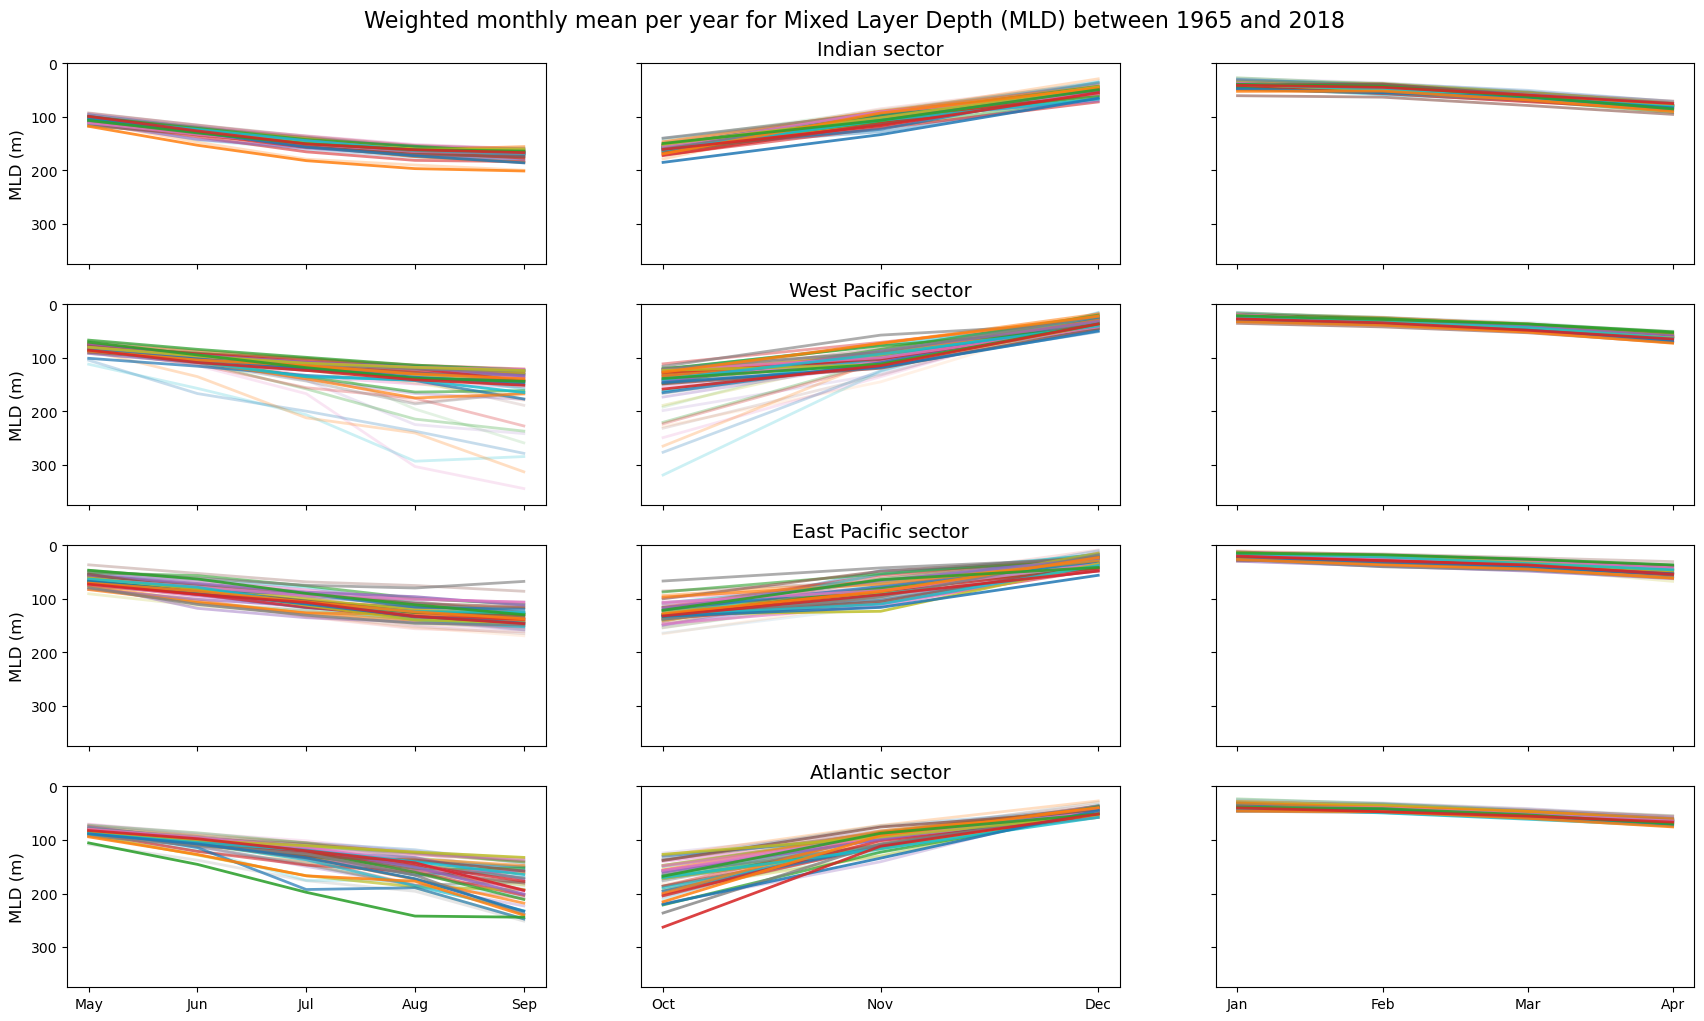

In [28]:
# comb_Ind, comb_WP, comb_EP, comb_Atl
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (21, 12))
Years = comb_Ind.season.values

Months1 = [calendar.month_abbr[m] for m in range(5, 10)]
Ind_May = comb_Ind.loc[:, Months1]

alpha = np.arange(0.1, 1., 0.03)
alpha = np.repeat(alpha, 2)

#########
#Indian sector
for i in range(0, len(Years)):
# #Plot line on the same figures - Months variable is used as X axis
    axes[0,0].plot(Months1, Ind_May.values[i],
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])

Months2 = [calendar.month_abbr[m] for m in range(10, 13)]
# y = xr.concat([comb_Ind.sel(month = slice(10, 12)), comb_Ind.sel(month = slice(1, 4))], dim="month")
Ind_Oct = comb_Ind.loc[:, Months2]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[0,1].plot(Months2, Ind_Oct.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])
axes[0,1].set_title('Indian sector', fontsize = 14)

Months3 = [calendar.month_abbr[m] for m in range(1, 5)]
Ind_Jan = comb_Ind.loc[:, Months3]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[0,2].plot(Months3, Ind_Jan.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])


#########
#West Pacific sector
WP_May = comb_WP.loc[:, Months1]
for i in range(0, len(Years)):
# #Plot line on the same figures - Months variable is used as X axis
    axes[1,0].plot(Months1, WP_May.values[i],
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])

WP_Oct = comb_WP.loc[:, Months2]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[1,1].plot(Months2, WP_Oct.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])
axes[1,1].set_title('West Pacific sector', fontsize = 14)

WP_Jan = comb_WP.loc[:, Months3]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[1,2].plot(Months3, WP_Jan.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])


#########
#East Pacific sector
EP_May = comb_EP.loc[:, Months1]
for i in range(0, len(Years)):
# #Plot line on the same figures - Months variable is used as X axis
    axes[2,0].plot(Months1, EP_May.values[i],
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])

EP_Oct = comb_EP.loc[:, Months2]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[2,1].plot(Months2, EP_Oct.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])
axes[2,1].set_title('East Pacific sector', fontsize = 14)

EP_Jan = comb_EP.loc[:, Months3]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[2,2].plot(Months3, EP_Jan.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])


#########
#Atlantic sector
Atl_May = comb_Atl.loc[:, Months1]
for i in range(0, len(Years)):
# #Plot line on the same figures - Months variable is used as X axis
    axes[3,0].plot(Months1, Atl_May.values[i],
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])

Atl_Oct = comb_Atl.loc[:, Months2]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[3,1].plot(Months2, Atl_Oct.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])
axes[3,1].set_title('Atlantic sector', fontsize = 14)

Atl_Jan = comb_Atl.loc[:, Months3]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[3,2].plot(Months3, Atl_Jan.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])

for ax in axes[0:3,:].flat:
    ax.set_xticklabels([])
for ax in axes[:,1:].flat:
    ax.set_yticklabels([])
for ax in axes[:, 0].flat:
#     ax.set_ylabel('SST ($^\circ$C)', fontsize = 12)
    ax.set_ylabel('MLD (m)', fontsize = 12)
for ax in axes.flat:
    ax.set_ylim(375, 0) #MLD
#     ax.set_ylim(-2, 5) #SST

# handles, labels = axes[0,0].get_legend_handles_labels()
#Plot shared legend, add title, make it horizontal and change its location to the top of the figure 
# fig.legend(handles, labels, title = 'Sectors', ncol = 10, loc = 'upper center', bbox_to_anchor = (0.5, 1.19))

plt.suptitle('Weighted monthly mean per year for Mixed Layer Depth (MLD) between 1965 and 2018', y = 0.925, fontsize = 16)
# plt.suptitle('Weighted monthly mean per year for Sea Surface Temperature (SST) between 1965 and 2018', y = 0.925)

plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/MLD/PolarZones/MeanSectorsMLD_ThreePanels_Monthly.png', dpi = 300)
# plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/PolarZones/MeanSectorsSST_ThreePanels_Monthly.png', dpi = 300)

**Plotting all sectors in one panel**

In [ ]:
#Intitialise figure
fig, ax = plt.subplots(figsize = (25, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Start plotting each sector
weightedIndian.plot(ax = ax, linewidth=0.5, marker='o',markersize=1.5, color = '#DDAA33', label = "Indian")
weightedWP.plot(ax = ax, linewidth=0.5, marker='o',markersize=1.5, color = '#BB5566', label = "West Pacific")
weightedEP.plot(ax = ax, linewidth=0.5, marker='o',markersize=1.5, color = '#004488', label = "East Pacific")
weightedAtlantic.plot(ax = ax, linewidth=0.5, marker='o',markersize=1.5, color = '#000000', label = "Atlantic")

#Add legend to graph - Add a title, change number of columns being shown, change location to the upper center, and use a med size font
ax.legend(title = "Sectors", ncol = 4, bbox_to_anchor = (0.5, 1.05), loc = 'upper center', fontsize = 'medium')
#Note for `bbox_to_anchor`, (0, 0) refers to the bottom left corner of the graph, and (1, 1) refers to the top right corner of the figure

#Remove x label
ax.set_xlabel("")
#Change y label
ax.set_ylabel("SST ($^\circ$C)")

#Add a title to the graph
ax.set_title('Mean Monthly Sea Surface Temperature (SST) in the Southern Ocean between 1965 and 2018', size = 16, y = 1.05)

#Saving the plot
plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/ContinentalShelf/MeanMonthlySST_AllSectorOnePanels.png', dpi = 350)

### Plotting monthly means per sector with subplots for min and max monthly values
Defining functions that calculate monthly mean, min and max values per decade and per year.

In [ ]:
def plot_decade(xarray, s_year, ax, stat = 'mean', **kwargs):
    '''
    Inputs:
    array - Data array containing variable from which decadal monthly means will be calculated
    s_year - The year when the decade starts
    ax - Plot axis where means will be plotted
    stat - It defines what calculations should be performed on the array. Accepts strings: mean, min and max. If no input is given is set to mean.
    **Optional (kwargs):
    *Note that both kwargs need to be provided if y axis limits are to be changed*
    minVal - changes the minimum value shown in the y axis
    maxVal - minVal - changes the maximum value shown in the y axis
    
    Output:
    Figure with a line showing the decadal monthly means in thick coloured lines
    '''
    
    #Slice the array to cover one decade of data starting from s_year
    array_dec = xarray.sel(time = slice(str(s_year), str(s_year + 9)))
        
    #Checking the stat parameter to perform the appropriate calculation.
    #Monthly means
    if stat == 'mean':
        monthly_mean_dec = array_dec.groupby('time.month').mean()
        ls = "-"
    #Minimum monthly values
    elif stat == 'min':
        monthly_mean_dec = array_dec.groupby('time.month').min()
        ls = ":"
    #Maximum monthly values
    elif stat == 'max':
        #Calculate monthly means from sliced array
        monthly_mean_dec = array_dec.groupby('time.month').max()
        ls = "--"
        
    #Create a vector with the month abbreviations in English to label x axis
    Months = [calendar.month_abbr[m] for m in range(1, 13)]
    
    #Extract maximum year value in the data array (used for labelling)
    MaxY = max(array_dec.indexes['time'].to_datetimeindex().year)
    
    #Plot line on the same figures - Months variable is used as X axis
    ax.plot(Months, monthly_mean_dec.values, 
            #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
            label = f'{s_year}-{MaxY}', 
            #Changing line width and line style
            linewidth = 2, linestyle = ls)
    
    #If minVal and maxVal kwargs are provided, then change the limit of the y axis
    if 'minVal' in kwargs.keys() and 'maxVal' in kwargs.keys():
        ax.set_ylim([kwargs.get('minVal'), kwargs.get('maxVal')])

**Creating composite graph**

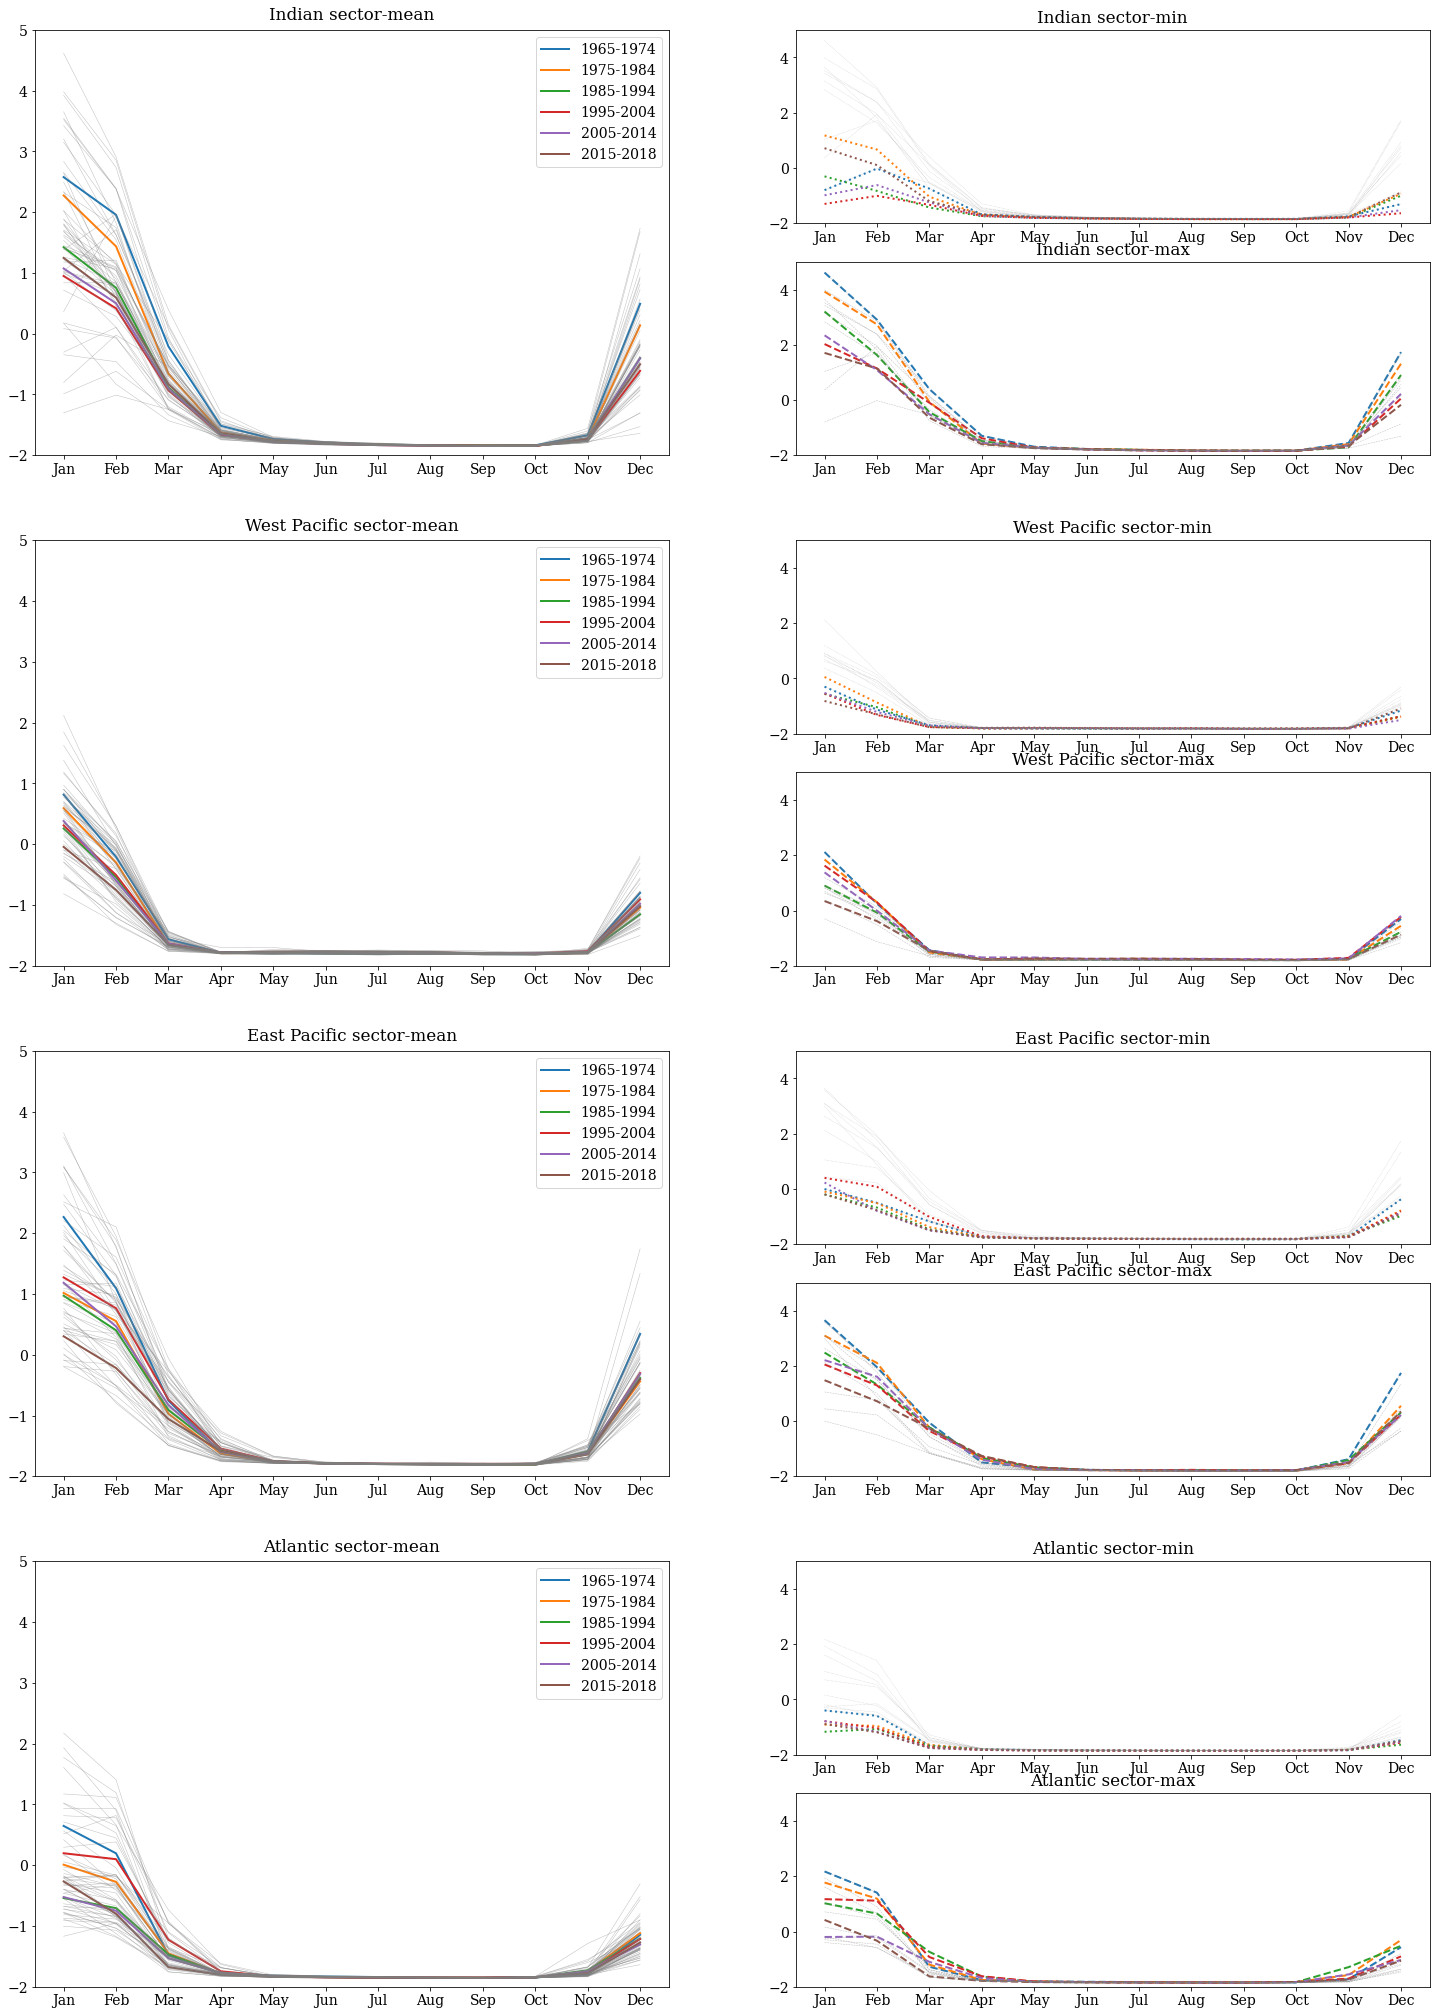

In [19]:
#Set minimum and maximum values to be used for y axis limits
minVal = -2
maxVal = 5

#Initialise graph
fig = plt.figure(figsize = (25, 36))
#Create a grid to plot all graphs together
gs = gridspec.GridSpec(nrows = 4, ncols = 2)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#####
#Indian sector
#Mean
meanV = fig.add_subplot(gs[0, 0])
#Apply the plot_decade function for the entire time period covered by ACCESS-OM2-01
for dec in range(1965, 2019, 10):
    plot_decade(weightedIndian, dec, meanV, stat = 'mean', minVal = minVal, maxVal = maxVal)
# #Apply the plot_year function for the entire time period covered by ACCESS-OM2-01
for year in range(1965, 2019):
    plot_year(weightedIndian, year, meanV)
meanV.set_title('Indian sector-mean', y = 1.01)
meanV.legend()

#Minimum
MinMax = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[0, 1])
minV = fig.add_subplot(MinMax[0])
for dec in range(1965, 2019, 10):
    plot_decade(weightedIndian, dec, minV, stat = 'min', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedIndian, year, minV, stat = 'min')
minV.set_title('Indian sector-min', y = 1.01)

#Maximum
maxV = fig.add_subplot(MinMax[1])
for dec in range(1965, 2019, 10):
    plot_decade(weightedIndian, dec, maxV, stat = 'max', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedIndian, year, maxV, stat = 'max')
maxV.set_title('Indian sector-max', y = 1.01)


#####
#West Pacific sector
#Mean
meanWP = fig.add_subplot(gs[1, 0])
#Apply the plot_decade function for the entire time period covered by ACCESS-OM2-01
for dec in range(1965, 2019, 10):
    plot_decade(weightedWP, dec, meanWP, stat = 'mean', minVal = minVal, maxVal = maxVal)
# #Apply the plot_year function for the entire time period covered by ACCESS-OM2-01
for year in range(1965, 2019):
    plot_year(weightedWP, year, meanWP)
meanWP.set_title('West Pacific sector-mean', y = 1.01)
meanWP.legend()

#Minimum
MinMaxWP = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[1, 1])
minWP = fig.add_subplot(MinMaxWP[0])
for dec in range(1965, 2019, 10):
    plot_decade(weightedWP, dec, minWP, stat = 'min', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedWP, year, minWP, stat = 'min')
minWP.set_title('West Pacific sector-min', y = 1.01)

#Maximum
maxWP = fig.add_subplot(MinMaxWP[1])
for dec in range(1965, 2019, 10):
    plot_decade(weightedWP, dec, maxWP, stat = 'max', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedWP, year, maxWP, stat = 'max')
maxWP.set_title('West Pacific sector-max', y = 1.01)


#####
#East Pacific sector
#Mean
meanEP = fig.add_subplot(gs[2, 0])
#Apply the plot_decade function for the entire time period covered by ACCESS-OM2-01
for dec in range(1965, 2019, 10):
    plot_decade(weightedEP, dec, meanEP, stat = 'mean', minVal = minVal, maxVal = maxVal)
# #Apply the plot_year function for the entire time period covered by ACCESS-OM2-01
for year in range(1965, 2019):
    plot_year(weightedEP, year, meanEP)
meanEP.set_title('East Pacific sector-mean', y = 1.01)
meanEP.legend()

#Minimum
MinMaxEP = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[2, 1])
minEP = fig.add_subplot(MinMaxEP[0])
for dec in range(1965, 2019, 10):
    plot_decade(weightedEP, dec, minEP, stat = 'min', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedEP, year, minEP, stat = 'min')
minEP.set_title('East Pacific sector-min', y = 1.01)

#Maximum
maxEP = fig.add_subplot(MinMaxEP[1])
for dec in range(1965, 2019, 10):
    plot_decade(weightedEP, dec, maxEP, stat = 'max', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedEP, year, maxEP, stat = 'max')
maxEP.set_title('East Pacific sector-max', y = 1.01)


#####
#Atlantic sector
meanA = fig.add_subplot(gs[3, 0])
#Apply the plot_decade function for the entire time period covered by ACCESS-OM2-01
for dec in range(1965, 2019, 10):
    plot_decade(weightedAtlantic, dec, meanA, stat = 'mean', minVal = minVal, maxVal = maxVal)
# #Apply the plot_year function for the entire time period covered by ACCESS-OM2-01
for year in range(1965, 2019):
    plot_year(weightedAtlantic, year, meanA)
meanA.set_title('Atlantic sector-mean', y = 1.01)
meanA.legend()

#Minimum 
minMaxA = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[3, 1])
minA = fig.add_subplot(minMaxA[0])
for dec in range(1965, 2019, 10):
    plot_decade(weightedAtlantic, dec, minA, stat = 'min', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedAtlantic, year, minA, stat = 'min')
minA.set_title('Atlantic sector-min', y = 1.01)

#Maximum
maxA = fig.add_subplot(minMaxA[1])
for dec in range(1965, 2019, 10):
    plot_decade(weightedAtlantic, dec, maxA, stat = 'max', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedAtlantic, year, maxA, stat = 'max')
maxA.set_title('Atlantic sector-max', y = 1.01)

#####
#Saving composite figure
plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/ContinentalShelf/MeanMinMaxMonthlySST_AllSectorFourPanels.png', dpi = 350)

### Plotting monthly means per sector with standard deviation error bars
Defining function to calculate decadal mean and standard deviation for every month

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  font

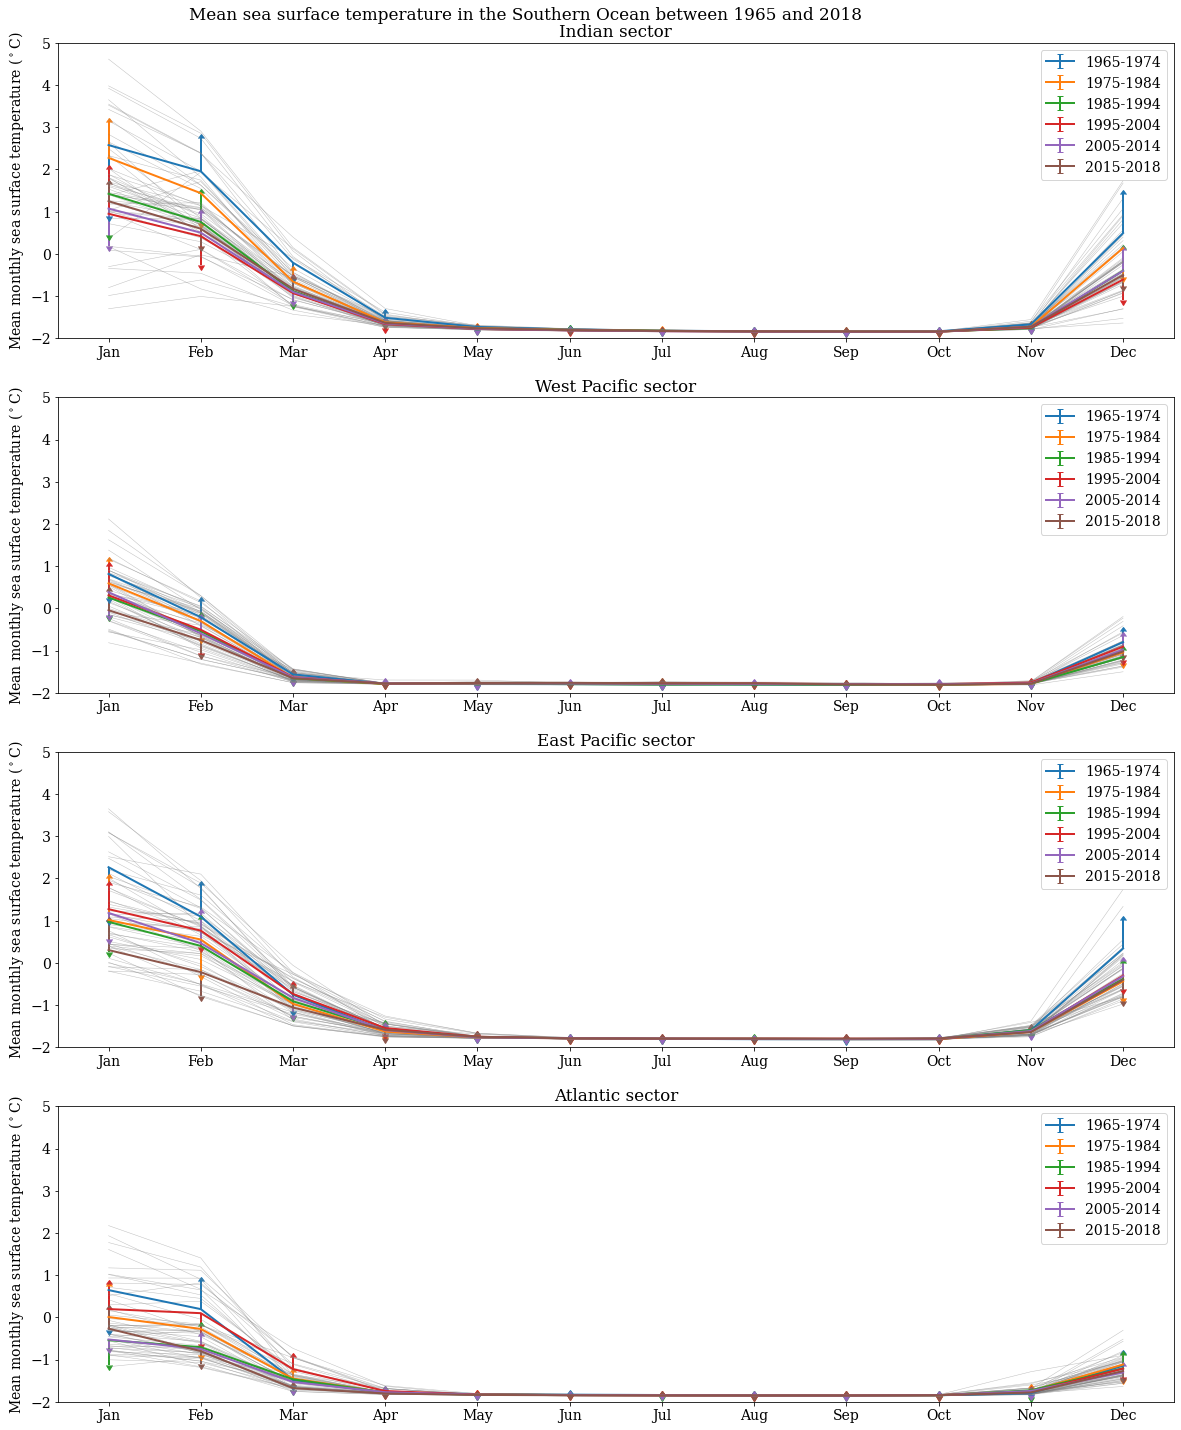

In [22]:
#Set minimum and maximum values to be used for y axis limits
minVal = -2
maxVal = 5

#Initialise graph
fig = plt.figure(figsize = (20, 25))
#Create a grid to plot all graphs together
gs = gridspec.GridSpec(nrows = 4, ncols = 1)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Defining decades to be included in the plot
decades = range(1965, 2019, 10)

#####
#Indian sector
#Apply the plot_decade function for the entire time period covered by ACCESS-OM2-01
Ind = fig.add_subplot(gs[0])
for i in range(0, len(decades)):
    plot_decadeMeanSD(weightedIndian, decades[i], Ind, stat = 'mean', minVal = minVal, maxVal = maxVal, counter = i)
#Apply the plot_year function for the entire time period covered by ACCESS-OM2-01
for year in range(1965, 2019):
    plot_year(weightedIndian, year, Ind)
Ind.set_title('Indian sector')
# Ind.set_ylabel('Mean monthly sea surface temperature ($^\circ$C)')
# Ind.legend()


#####
#West Pacific sector
WP = fig.add_subplot(gs[1])
for i in range(0, len(decades)):
    plot_decadeMeanSD(weightedWP, decades[i], WP, minVal = minVal, maxVal = maxVal, counter = i)
for year in range(1965, 2019):
    plot_year(weightedWP, year, WP)
WP.set_title('West Pacific sector')


#####
#East Pacific sector
EP = fig.add_subplot(gs[2])
for i in range(0, len(decades)):
    plot_decadeMeanSD(weightedEP, decades[i], EP, minVal = minVal, maxVal = maxVal, counter = i)
for year in range(1965, 2019):
    plot_year(weightedEP, year, EP)
EP.set_title('East Pacific sector')


#####
#Atlantic sector
Atl = fig.add_subplot(gs[3])
for i in range(0, len(decades)):
    plot_decadeMeanSD(weightedAtlantic, decades[i], Atl, minVal = minVal, maxVal = maxVal, counter = i)
for year in range(1965, 2019):
    plot_year(weightedAtlantic, year, Atl)
Atl.set_title('Atlantic sector')

#Remove x tick labels so the plot does not look too crowded
plt.setp([a.set_ylabel('Mean monthly sea surface temperature ($^\circ$C)') for a in [Ind, WP, EP, Atl]])
plt.setp([a.legend() for a in [Ind, WP, EP, Atl]])
    
#Set title for composite figure. Move the title along the y axis so it is not too far from 
fig.suptitle('Mean sea surface temperature in the Southern Ocean between 1965 and 2018', y = 0.90, x = 0.45)

plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/ContinentalShelf/MeanSDMonthlySST_AllSectorsFourPanels.png', dpi = 350)

In [ ]:
minVal = np.floor(min(weightedIndian).values*0.9)
print(minVal)
maxVal = np.floor(max(weightedIndian).values*1.1)
print(maxVal)

In [ ]:
# weightedIndian.resample(time = '10Y').mean().plot()
weightedIndian.time.dt.strftime("%b %Y")

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize = (25, 10))
#Create a grid layout to place all subplots in one figure - 4x4 grid created to center bottom plot
gs = gridspec.GridSpec(nrows = 2, ncols = 2)

Ind = fig.add_subplot(gs[0, 0])
p_Ind = weightedIndian.plot(ax = Ind, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'g')
#Add subplot title
Ind.set_title('Indian', y = 1.01)

WP = fig.add_subplot(gs[0, 1])
p_WP = weightedWP.plot(ax = WP, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'red')
WP.set_title('West Pacific', y = 1.01)

EP = fig.add_subplot(gs[1, 0])
p_EP = weightedEP.plot(ax = EP, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'blue')
EP.set_title('East Pacific', y = 1.01)

Atl = fig.add_subplot(gs[1, 1])
p_Atl = weightedAtlantic.plot(ax = Atl, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'orange')
Atl.set_title('Atlantic', y = 1.01)

### Other 

In [ ]:
def plot_decade(xarray, s_year, ax, stat = 'mean', **kwargs):
    '''
    Inputs:
    array - Data array containing variable from which decadal monthly means will be calculated
    s_year - The year when the decade starts
    ax - Plot axis where means will be plotted
    stat - It defines what calculations should be performed on the array. Accepts strings: mean, min and max. If no input is given is set to mean.
    **Optional (kwargs):
    *Note that both kwargs need to be provided if y axis limits are to be changed*
    minVal - changes the minimum value shown in the y axis
    maxVal - minVal - changes the maximum value shown in the y axis
    
    Output:
    Figure with a line showing the decadal monthly means in thick coloured lines
    '''
    
    #Slice the array to cover one decade of data starting from s_year
    array_dec = xarray.sel(time = slice(str(s_year), str(s_year + 9)))
        
    #Checking the stat parameter to perform the appropriate calculation.
    #Monthly means
    if stat == 'mean':
        monthly_mean_dec = array_dec.groupby('time.month').mean()
        ls = "-"
    #Minimum monthly values
    elif stat == 'min':
        monthly_mean_dec = array_dec.groupby('time.month').min()
        ls = ":"
    #Maximum monthly values
    elif stat == 'max':
        #Calculate monthly means from sliced array
        monthly_mean_dec = array_dec.groupby('time.month').max()
        ls = "--"
        
    #Create a vector with the month abbreviations in English to label x axis
    Months = [calendar.month_abbr[m] for m in range(1, 13)]
    
    #Extract maximum year value in the data array (used for labelling)
    MaxY = max(array_dec.indexes['time'].to_datetimeindex().year)
    
    #Plot line on the same figures - Months variable is used as X axis
    ax.plot(Months, monthly_mean_dec.values, 
            #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
            label = f'{s_year}-{MaxY}', 
            #Changing line width and line style
            linewidth = 2, linestyle = ls)
    
    #If minVal and maxVal kwargs are provided, then change the limit of the y axis
    if 'minVal' in kwargs.keys() and 'maxVal' in kwargs.keys():
        ax.set_ylim([kwargs.get('minVal'), kwargs.get('maxVal')])

In [ ]:
def plot_year(array, year, ax, stat = 'mean'):
    '''
    Inputs:
    array - Data array containing variable from which yearly monthly means will be calculated
    year - The year for which means will be calculated
    ax - Plot axis where means will be plotted
    stat - It defines what calculations should be performed on the array. Accepts strings: mean, min and max. If no input is given is set to mean.
    
    Output:
    Figure with a line showing the yearly monthly means in thin grey lines
    '''
    
    #Slice the array to cover the year of interest
    array_yr = array.sel(time = str(year))
    
    #Checking the stat parameter to perform the appropriate calculation.
    #Monthly means
    if stat == 'mean':
        monthly_mean_yr = array_yr.groupby('time.month').mean()
        ls = "-"
    #Minimum monthly value
    elif stat == 'min':
        monthly_mean_yr = array_yr.groupby('time.month').min()
        ls = ":"
    #Maximum monthly value
    elif stat == 'max':
        monthly_mean_yr = array_yr.groupby('time.month').max()
        ls = "--"
    
    #Create a vector with the month abbreviations in English to label x axis
    Months = [calendar.month_abbr[m] for m in monthly_mean_yr.month.values]
    
    #Plot means with month abbreviations as x axis. Create a label for the line that will show the year that was plotted in grey
    ax.plot(Months, monthly_mean_yr.values, color = 'grey', linewidth = 0.5, alpha = 0.5, linestyle = ls)

In [20]:
def plot_decadeMeanSD(xarray, s_year, ax, stat = 'mean', **kwargs):
    '''
    Inputs:
    array - Data array containing variable from which decadal monthly means will be calculated
    s_year - The year when the decade starts
    ax - Plot axis where means will be plotted
    stat - It defines what calculations should be performed on the array. Accepts strings: mean, min and max. If no input is given is set to mean.
    **Optional (kwargs):
    *Note that both kwargs need to be provided if y axis limits are to be changed*
    minVal - changes the minimum value shown in the y axis
    maxVal - minVal - changes the maximum value shown in the y axis
    counter - used to alternate showing upper or lower error bars
    
    Output:
    Figure with a line showing the decadal monthly means in thick coloured lines with standard deviation shown by error bars
    '''
    
    #Slice the array to cover one decade of data starting from s_year
    array_dec = xarray.sel(time = slice(str(s_year), str(s_year + 9)))
    
    #Checking the stat parameter to perform the appropriate calculation.
    #Monthly means and standard deviation
    if stat == 'mean':
        monthly_mean_dec = array_dec.groupby('time.month').mean()
        monthly_mean_std = array_dec.groupby('time.month').std()
        ls = "-"
    #Minimim monthly values
    elif stat == 'min':
        monthly_mean_dec = array_dec.groupby('time.month').min()
        ls = ":"
    #Calculate monthly maximum from sliced array
    elif stat == 'max':
        monthly_mean_dec = array_dec.groupby('time.month').max()
        ls = "--"
        
    #Create a vector with the month abbreviations in English to label x axis
    Months = [calendar.month_abbr[m] for m in range(1, 13)]
    
    #Identifying the maximum year included in the decadal calculations
    MaxY = max(array_dec.indexes['time'].to_datetimeindex().year)
    
    #Lower and upper error bars are shown alternating so the plot does not look too crowded
    if 'counter' in kwargs.keys() and (kwargs.get('counter')%2 == 0):
        upperlimits = [True, False] * 6
        lowerlimits = [False, True] * 6
    elif 'counter' in kwargs.keys() and (kwargs.get('counter')%2 != 0):
        upperlimits = [False, True] * 6
        lowerlimits = [True, False] * 6
    
    #If mean calculations are chosen, then 
    if stat == 'mean':
        ax.errorbar(Months, monthly_mean_dec.values, 
                    #Error bars will show standard deviation values
                    yerr = monthly_mean_std, label = f'{s_year}-{MaxY}', linewidth = 2, linestyle = ls, uplims = upperlimits, lolims = lowerlimits)
    #For min and max calculations, a single line with no error bars is shown
    elif stat != 'mean':
        ax.plot(Months, monthly_mean_dec.values, label = f'{s_year}-{MaxY}', linewidth = 2, linestyle = ls)
    
    #Changing range of y axis
    if 'minVal' in kwargs.keys() and 'maxVal' in kwargs.keys():
        ax.set_ylim([kwargs.get('minVal'), kwargs.get('maxVal')])